<a href="https://colab.research.google.com/github/KeeganMcWW/ml-projects/blob/main/IASIM2016_Challenege_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import and set up the Colab

In [ ]:
import scipy.io as sio
import os
import matplotlib.pyplot as plt
import numpy as np

from google.colab import files
from scipy import linalg
from scipy.signal import savgol_filter
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [ ]:
%matplotlib inline

In [ ]:
machine_data_path = r'/content/data_files/'
try:
    os.mkdir(machine_data_path)
except OSError:
      print ("Creation of the directory %s failed" % machine_data_path)
else:
    print ("Successfully created the directory %s " % machine_data_path)

Successfully created the directory /content/data_files/ 


In [ ]:
!wget https://eigenvector.com/wp-content/uploads/2021/03/IASIM16ChallengeProblem.zip

--2021-10-16 08:08:12--  https://eigenvector.com/wp-content/uploads/2021/03/IASIM16ChallengeProblem.zip
Resolving eigenvector.com (eigenvector.com)... 69.163.163.60, 2607:f298:6:a034::eaf:812c
Connecting to eigenvector.com (eigenvector.com)|69.163.163.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 448641963 (428M) [application/zip]
Saving to: ‘IASIM16ChallengeProblem.zip’

IASIM16ChallengePro 100%[===================>] 427.86M  25.8MB/s    in 15s     

2021-10-16 08:08:27 (29.3 MB/s) - ‘IASIM16ChallengeProblem.zip’ saved [448641963/448641963]



In [ ]:
!unzip IASIM16ChallengeProblem.zip -d data_files

Archive:  IASIM16ChallengeProblem.zip
   creating: data_files/ForTheJudges/
  inflating: data_files/ForTheJudges/Hyperspectral_FACSS2011_NBGb.pdf  
  inflating: data_files/ForTheJudges/InformationForJudges.pdf  
  inflating: data_files/IASIM_2016_Challenge.pdf  
 extracting: data_files/M_200ppm.mat  
 extracting: data_files/Melamine_Pure.mat  
 extracting: data_files/Test_1.mat   
 extracting: data_files/Test_2.mat   
 extracting: data_files/Test_3.mat   
 extracting: data_files/Wheat_Gluten_Pure.mat  
   creating: data_files/__MACOSX/
  inflating: data_files/__MACOSX/._IASIM_2016_Challenge.pdf  
  inflating: data_files/__MACOSX/._M_200ppm.mat  
  inflating: data_files/__MACOSX/._Melamine_Pure.mat  
  inflating: data_files/__MACOSX/._Test_1.mat  
  inflating: data_files/__MACOSX/._Test_2.mat  
  inflating: data_files/__MACOSX/._Test_3.mat  
   creating: data_files/__MACOSX/ForTheJudges/
  inflating: data_files/__MACOSX/ForTheJudges/._Hyperspectral_FACSS2011_NBGb.pdf  
  inflating: data

### Helper functions

In [ ]:
# https://stackoverflow.com/questions/7008608/scipy-io-loadmat-nested-structures-i-e-dictionaries
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], sio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, sio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, sio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = sio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

### Examining the Data

In [ ]:
wheat_gluten_pure = loadmat('/content/data_files/Wheat_Gluten_Pure.mat')
melamine_pure = loadmat('/content/data_files/Melamine_Pure.mat')
m_200ppm = loadmat('/content/data_files/M_200ppm.mat')

Data is imported with as a dict with nestled dicts. The important dict is the 'z' dictionary, which contains the important information.

In [ ]:
print(wheat_gluten_pure['z'].keys())

dict_keys(['name', 'type', 'author', 'date', 'moddate', 'imagesize', 'imagemode', 'data', 'label', 'axisscale', 'imageaxisscale', 'title', 'class', 'include', 'classlookup', 'axistype', 'imageaxistype', 'description', 'userdata', 'datasetversion', 'history', 'uniqueid'])


In [ ]:
x_size, y_size = wheat_gluten_pure['z']['imagesize']
z_size = np.shape(wheat_gluten_pure['z']['data'])[1]
print(x_size, y_size, z_size)

243 244 229


In [ ]:
wheat_gluten_pure_data_mat = np.reshape(wheat_gluten_pure['z']['data'], (x_size, y_size, z_size), order = 'F')
melamine_pure_data_mat = np.reshape(melamine_pure['z']['data'], (x_size, y_size, z_size), order = 'F')
m_200ppm_data_mat = np.reshape(m_200ppm['z']['data'], (x_size, y_size, z_size), order = 'F')

lets take a look at the image. Here I am just slicing along the z axis. Each pixel is just the intensity at the given spectral point. For example, when z_slice = 0 we are looking at the reflectance instensity at 1120nm for the image. 

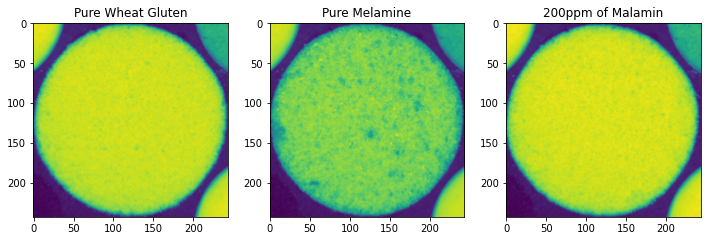

In [ ]:
z_slice = 114 #@param {type: "slider", min: 0, max: 228}
fig, ax = plt.subplots(1,3, figsize=(10, 10));
plt.tight_layout();
ax[0].imshow(wheat_gluten_pure_data_mat[:, :, z_slice]);
ax[0].set_title('Pure Wheat Gluten');
ax[1].imshow(melamine_pure_data_mat[:, :, z_slice]);
ax[1].set_title('Pure Melamine');
ax[2].imshow(m_200ppm_data_mat[:, :, z_slice]);
ax[2].set_title('200ppm of Malamin');

No we can slice along one of the axis to check out the spectral data. Here I am slicing along the x axis. 

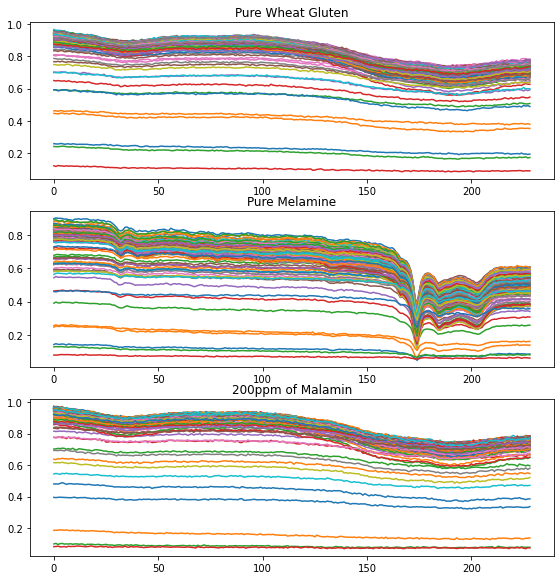

In [ ]:
x_slice = 122 #@param {type: "slider", min: 0, max: 242}
fig, ax = plt.subplots(3,1, figsize=(8,8));
plt.tight_layout()
ax[0].plot(wheat_gluten_pure_data_mat[x_slice, :, :].T)
ax[0].set_title('Pure Wheat Gluten');
ax[1].plot(melamine_pure_data_mat[x_slice, :, :].T)
ax[1].set_title('Pure Melamine');
ax[2].plot(m_200ppm_data_mat[x_slice, :, :].T)
ax[2].set_title('200ppm of Malamin');
plt.show()

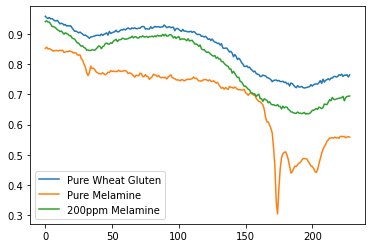

In [ ]:
fig, ax = plt.subplots()
ax.plot(wheat_gluten_pure_data_mat[122, 122, :].T, label = 'Pure Wheat Gluten')
ax.plot(melamine_pure_data_mat[122, 122, :].T, label = 'Pure Melamine')
ax.plot(m_200ppm_data_mat[122, 122, :].T, label = '200ppm Melamine')
ax.legend()
plt.show()

In [ ]:
crop_size = 100
left = int(np.floor((x_size - crop_size)/2))
top = int(np.floor((y_size - crop_size)/2))
right = int(np.floor((x_size + crop_size)/2))
bottom = int(np.floor((y_size + crop_size)/2))

wheat_cropped = wheat_gluten_pure_data_mat[left:right, top:bottom, :]
melamine_cropped = melamine_pure_data_mat[left:right, top:bottom, :]
m_200ppm_cropped = m_200ppm_data_mat[left:right, top:bottom, :]

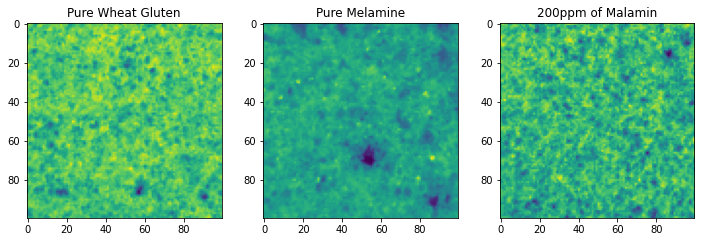

In [ ]:
z_slice = 106 #@param {type: "slider", min: 0, max: 242}
fig, ax = plt.subplots(1,3, figsize=(10, 10));
plt.tight_layout();
ax[0].imshow(wheat_cropped[:, :, z_slice]);
ax[0].set_title('Pure Wheat Gluten');
ax[1].imshow(melamine_cropped[:, :, z_slice]);
ax[1].set_title('Pure Melamine');
ax[2].imshow(m_200ppm_cropped[:, :, z_slice]);
ax[2].set_title('200ppm of Malamin');

In [ ]:
def apply_sgfilter(matrix, window_length, polyorder, deriv):
  output = np.empty(np.shape(matrix))
  for i in range(len(matrix)):
    for j in range(len(matrix[0])):
      output[i][j] = savgol_filter(matrix[i, j, :], window_length, polyorder, deriv=deriv)
      #output[i][j] = np.gradient(sg_filter)
  return output

In [ ]:
 def pca_whitening(x):
    # Center data
    # By subtracting mean for each feature
    xc = x.T - np.mean(x.T, axis=0)
    xc = xc.T

    # Calculate covariance matrix
    xcov = np.cov(xc, rowvar=True, bias=True)

    # Calculate Eigenvalues and Eigenvectors
    w, v = linalg.eig(xcov)

    # Calculate inverse square root of Eigenvalues
    # Add '.1e5' to avoid division errors if needed
    # Create a diagonal matrix
    diagw = np.diag(1/((w+.1e-6)**0.5))
    diagw = diagw.real.round(8) #convert to real and round off

    # Whitening transform using PCA (Principal Component Analysis)
    # wpca = np.dot(np.dot(diagw, v.T), xc)
    # return the diagonal matrix and Eiganvectors 
    return diagw, v

In [ ]:
wheat_preprocessed = apply_sgfilter(wheat_cropped, 5, 2, 1)
meamine_preprocessed = apply_sgfilter(melamine_cropped, 5, 2, 1)
m_200ppm_preprocessed = apply_sgfilter(m_200ppm_cropped, 5, 2, 1)

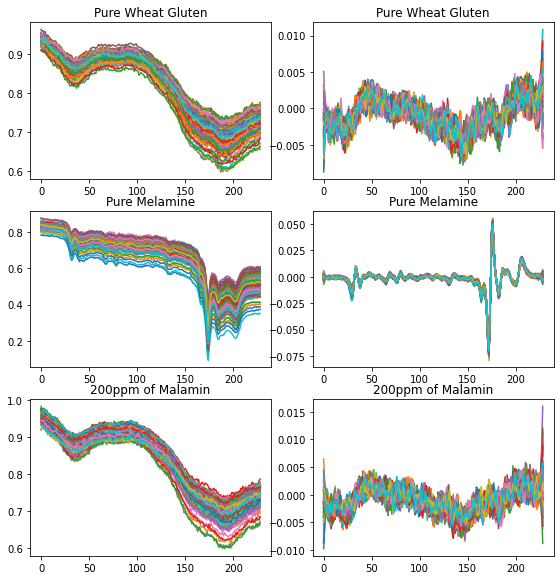

In [ ]:
x_slice = 49 #@param {type: "slider", min: 0, max: 99}
fig, axs = plt.subplots(3, 2, figsize=(8,8))
plt.tight_layout()
axs[0, 0].plot(wheat_cropped[x_slice, :, :].T)
axs[0, 0].set_title('Pure Wheat Gluten');
axs[1, 0].plot(melamine_cropped[x_slice, :, :].T)
axs[1, 0].set_title('Pure Melamine');
axs[2, 0].plot(m_200ppm_cropped[x_slice, :, :].T)
axs[2, 0].set_title('200ppm of Malamin');
axs[0, 1].plot(wheat_preprocessed[x_slice, :, :].T)
axs[0, 1].set_title('Pure Wheat Gluten');
axs[1, 1].plot(meamine_preprocessed[x_slice, :, :].T)
axs[1, 1].set_title('Pure Melamine');
axs[2, 1].plot(m_200ppm_preprocessed[x_slice, :, :].T)
axs[2, 1].set_title('200ppm of Malamin');
plt.show()

In [ ]:
def create_label(matrix, label):
  output = np.empty(np.shape(matrix[:,:,-1]))
  for i in range(len(matrix)):
    for j in range(len(matrix[0])):
      output[i][j] = label
  return output

In [ ]:
wheat_labels = create_label(wheat_preprocessed, 0)
melamine_labels = create_label(meamine_preprocessed, 1)
#m_200ppm_labels = create_label(m_200ppm_preprocessed, 200/1000000)
m_200ppm_labels = create_label(m_200ppm_preprocessed, 1)

In [ ]:
val_split = 0.3
wheat_preprocessed_flat = np.reshape(wheat_preprocessed, (crop_size * crop_size, z_size), order = 'F')
meamine_preprocessed_flat = np.reshape(meamine_preprocessed, (crop_size * crop_size, z_size), order = 'F')
m_200ppm_preprocessed_flat = np.reshape(m_200ppm_preprocessed, (crop_size * crop_size, z_size), order = 'F')
wheat_labels_flat = np.reshape(wheat_labels, (crop_size * crop_size), order = 'F')
melamine_labels_flat = np.reshape(melamine_labels, (crop_size * crop_size), order = 'F')
m_200ppm_labels_flat = np.reshape(m_200ppm_labels, (crop_size * crop_size), order = 'F')
dataset = np.concatenate((wheat_preprocessed_flat, meamine_preprocessed_flat, m_200ppm_preprocessed_flat))
labels = np.concatenate((wheat_labels_flat, melamine_labels_flat, m_200ppm_labels_flat))

In [ ]:
print(np.shape(dataset))
print(np.shape(labels))

(30000, 229)
(30000,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=val_split, random_state=0)
cv = KFold(n_splits=5, random_state=1, shuffle=True)

In [ ]:
model = svm.SVC()
model.fit(dataset, labels)

In [ ]:
scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

In [ ]:
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.910 (0.004)


In [ ]:
model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
test = 0
print(y_test[test])
print(model.predict(X_test[test].reshape(1, -1)))

0.0
[0.]


In [ ]:
def predict(matrix, model):
  output = np.empty(np.shape(matrix[:,:,-1]))
  for i in range(len(matrix)):
    for j in range(len(matrix[0])):
      output[i][j] = model.predict(matrix[i, j].reshape(1, -1))
  return output

In [ ]:
test_1 = loadmat('/content/data_files/Test_1.mat')
test_1_mat = np.reshape(test_1['z']['data'], (x_size, y_size, z_size), order = 'F')
test_1_preprocessed = apply_sgfilter(test_1_mat, 5, 2, 1)
test_1_predict = predict(test_1_mat, model)

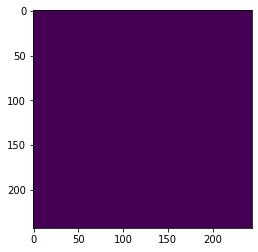

In [ ]:
plt.imshow(test_1_predict)